In [1]:
import os
import random
import time

import imageio.v2 as imageio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import make_grid, save_image

# Import checkpoint utilities
from Model import save_checkpoint_generic, load_checkpoint_generic

In [2]:
# # DCGAN Training Setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#
# batch_size = 512
# image_size = 64
# nc = 3
# noise_size = 100
# num_epochs = 500
# lr = 0.0002
# beta1 = 0.5
#
# # Transforms
# transform = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.CenterCrop(image_size),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5] * nc, [0.5] * nc),
# ])
#
# from Model import DCGAN_Dataset
# data_root = "./Dataset/tpdne_faces"
# out_dir = "./output_dcgan"
# if not os.path.exists(data_root):
#     raise FileNotFoundError("Dataset not found")
# os.makedirs(out_dir, exist_ok=True)
#
# dataset = DCGAN_Dataset(data_root, transform=transform)
# dataloader = torch.utils.data.DataLoader(
#     dataset,
#     # batch_size=batch_size,
#     batch_size=len(dataset),
#     shuffle=True,
#     num_workers=0,
#     drop_last=False,
#     pin_memory=True
# )
#
# # seed
# manualSeed = 999
# random.seed(manualSeed)
# torch.manual_seed(manualSeed)
#
# # Initialize models
# from Model import DCGAN_Generator, DCGAN_Discriminator
# generator = DCGAN_Generator(z_dim=noise_size, img_channels=nc).to(device)
# discriminator = DCGAN_Discriminator(img_channels=nc).to(device)
#
# criterionG = nn.BCELoss()
# criterionD = nn.BCELoss()
#
# optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999), foreach=False)
# optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999), foreach=False)
#
# # Training config to save with checkpoints
# training_config = {
#     'batch_size': batch_size,
#     'image_size': image_size,
#     'nc': nc,
#     'noise_size': noise_size,
#     'num_epochs': num_epochs,
#     'lr': lr,
#     'beta1': beta1,
#     'manualSeed': manualSeed,
# }


In [3]:
# # TRAIN LOOP DCGAN
# torch.cuda.empty_cache()
#
# # Initialize variables first
# start_epoch = 0
# G_losses = []
# D_losses = []
# loaded_noise = None
#
# real_label = 1.
# fake_label = 0.
# img_list = []
#
# # Load checkpoint (if exists)
# checkpoint = load_checkpoint_generic(out_dir, device)
# # checkpoint = load_checkpoint_generic_compat(out_dir, device)
# if checkpoint:
#     generator.load_state_dict(checkpoint['generator'])
#     discriminator.load_state_dict(checkpoint['discriminator'])
#     optimizerG.load_state_dict(checkpoint['optimizer_G'])
#     optimizerD.load_state_dict(checkpoint['optimizer_D'])
#     start_epoch = checkpoint['epoch']
#     G_losses = checkpoint.get('G_losses', [])
#     D_losses = checkpoint.get('D_losses', [])
#     loaded_noise = checkpoint.get('fixed_noise')
#     config = checkpoint.get('config', {})
#
# # Initialize or use loaded fixed noise
# if loaded_noise is not None:
#     fixed_noise = loaded_noise.to(device)
#     print("Using loaded fixed_noise from checkpoint")
# else:
#     fixed_noise = torch.randn(64, noise_size, 1, 1, device=device)
#     print("Created new fixed_noise for visualization")
#
# print("Starting Training Loop on device:", device)
# print(f"Training from epoch {start_epoch + 1} to {num_epochs}")
# iters = len(G_losses)
# start_time = time.time()
#
# for epoch in range(start_epoch + 1, num_epochs + 1):
#     epoch_start = time.time()
#
#     # ✅ Set models to training mode
#     generator.train()
#     discriminator.train()
#
#     for i, data in enumerate(dataloader, 0):
#
#         ############################
#         # (1) Update Discriminator
#         ############################
#         discriminator.zero_grad()
#
#         real_images = data.to(device)
#         b_size = real_images.size(0)
#         label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
#
#         output = discriminator(real_images).view(-1)
#         errD_real = criterionD(output, label)
#         errD_real.backward()
#         D_x = output.mean().item()
#
#         noise = torch.randn(b_size, noise_size, 1, 1, device=device)
#         fake = generator(noise)
#         label.fill_(fake_label)
#
#         output = discriminator(fake.detach()).view(-1)
#         errD_fake = criterionD(output, label)
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#
#         errD = errD_real + errD_fake
#         optimizerD.step()
#
#         ############################
#         # (2) Update Generator
#         ############################
#         generator.zero_grad()
#         label.fill_(real_label)
#
#         output = discriminator(fake).view(-1)
#         errG = criterionG(output, label)
#         errG.backward()
#         D_G_z2 = output.mean().item()
#
#         optimizerG.step()
#
#         G_losses.append(errG.item())
#         D_losses.append(errD.item())
#
#         if i % 50 == 0:
#             print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
#                   f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
#                   f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")
#
#         iters += 1
#
#     generator.eval()
#
#     # End of epoch: save sample grid
#     with torch.no_grad():
#         fake_fixed = generator(fixed_noise).detach().cpu()
#
#     grid = make_grid(fake_fixed, nrow=8, normalize=True, scale_each=True)
#     epoch_img_path = os.path.join(out_dir, f"epoch_{epoch:04d}.png")
#     save_image(grid, epoch_img_path)
#     img_list.append(epoch_img_path)
#
#     # ✅ Clear memory only after epoch (not every batch)
#     del fake_fixed, grid
#     torch.cuda.empty_cache()
#
#     epoch_time = time.time() - epoch_start
#     print(f"End epoch {epoch}/{num_epochs}  time: {epoch_time:.1f}s  saved: {epoch_img_path}")
#
#     if epoch % 10 == 0 or epoch == num_epochs:
#         # Save
#         save_checkpoint_generic(out_dir, epoch, {
#             'generator': generator.state_dict(),
#             'discriminator': discriminator.state_dict(),
#             'optimizer_G': optimizerG.state_dict(),
#             'optimizer_D': optimizerD.state_dict(),
#             'G_losses': G_losses,
#             'D_losses': D_losses,
#             'fixed_noise': fixed_noise,
#             'config': training_config,
#         })
#
#
# total_time = time.time() - start_time
# print(f"Training finished in {total_time / 60:.2f} minutes.")

In [4]:
# CycleGAN Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# dataset_root = "./Dataset/apple2orange"
dataset_root = "./Dataset/Summer2Winter_Yosemite"
data_root_A = os.path.join(dataset_root, "trainA")
data_root_B = os.path.join(dataset_root, "trainB")
test_root_A = os.path.join(dataset_root, "testA")
test_root_B = os.path.join(dataset_root, "testB")
# data_root_A = "./Dataset/apple2orange/trainA"
# data_root_B = "./Dataset/apple2orange/trainB"
# test_root_A = "./Dataset/apple2orange/testA"
# test_root_B = "./Dataset/apple2orange/testB"

# out_dir = "output_cyclegan_a2o"
out_dir = "output_cyclegan_s2w"
image_size = 256
batch_size = 4
num_epochs = 50
lr = 0.0002
beta1 = 0.5
lambda_cycle = 10.0
lambda_identity = 5.0

# Transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

from Model import CycleGAN_Dataset

os.makedirs(out_dir, exist_ok=True)

# Training dataset
dataset = CycleGAN_Dataset(data_root_A, data_root_B, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Test dataset (fixed samples)
test_dataset = CycleGAN_Dataset(test_root_A, test_root_B, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# Seed
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Initialize models
from Model import CycleGAN_Generator, CycleGAN_Discriminator

G_A2B = CycleGAN_Generator().to(device)
G_B2A = CycleGAN_Generator().to(device)
D_A = CycleGAN_Discriminator().to(device)
D_B = CycleGAN_Discriminator().to(device)

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = optim.Adam(
    list(G_A2B.parameters()) + list(G_B2A.parameters()),
    lr=lr, betas=(beta1, 0.999)
)
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

# Training config
training_config = {
    'batch_size': batch_size,
    'image_size': image_size,
    'num_epochs': num_epochs,
    'lr': lr,
    'beta1': beta1,
    'lambda_cycle': lambda_cycle,
    'lambda_identity': lambda_identity,
    'manualSeed': manualSeed,
}

In [8]:
# Training loop CycleGAN
torch.cuda.empty_cache()

start_epoch = 0
G_losses = []
D_A_losses = []
D_B_losses = []
test_A = None
test_B = None

# Load checkpoint
checkpoint = load_checkpoint_generic(out_dir, device)
if checkpoint:
    G_A2B.load_state_dict(checkpoint['G_A2B'])
    G_B2A.load_state_dict(checkpoint['G_B2A'])
    D_A.load_state_dict(checkpoint['D_A'])
    D_B.load_state_dict(checkpoint['D_B'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G'])
    optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A'])
    optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B'])
    start_epoch = checkpoint['epoch']
    G_losses = checkpoint.get('G_losses', [])
    D_A_losses = checkpoint.get('D_A_losses', [])
    D_B_losses = checkpoint.get('D_B_losses', [])
    test_A = checkpoint.get('test_A')
    test_B = checkpoint.get('test_B')
    config = checkpoint.get('config', {})

# Get fixed test samples (or use loaded ones)
if test_A is None or test_B is None:
    test_A, test_B = next(iter(test_loader))
    test_A = test_A.to(device)
    test_B = test_B.to(device)
    print("Created new fixed test samples")
else:
    test_A = test_A.to(device)
    test_B = test_B.to(device)
    print("Using loaded fixed test samples from checkpoint")

print(f"Starting CycleGAN training on {device}")
print(f"Training from epoch {start_epoch + 1} to {num_epochs}")
start_time = time.time()

for epoch in range(start_epoch + 1, num_epochs + 1):
    epoch_start = time.time()

    G_A2B.train()
    G_B2A.train()
    D_A.train()
    D_B.train()

    for i, (real_A, real_B) in enumerate(dataloader):
        batch_start = time.time()
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        batch_size_curr = real_A.size(0)
        real_label = torch.ones(batch_size_curr, 1, 30, 30, device=device)
        fake_label = torch.zeros(batch_size_curr, 1, 30, 30, device=device)

        # =====================================
        # Train Generators
        # =====================================
        optimizer_G.zero_grad()

        # Identity loss
        identity_A = G_B2A(real_A)
        loss_identity_A = criterion_identity(identity_A, real_A)

        identity_B = G_A2B(real_B)
        loss_identity_B = criterion_identity(identity_B, real_B)

        # GAN loss
        fake_B = G_A2B(real_A)
        pred_fake_B = D_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake_B, real_label)

        fake_A = G_B2A(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake_A, real_label)

        # Cycle consistency loss
        recovered_A = G_B2A(fake_B)
        loss_cycle_A = criterion_cycle(recovered_A, real_A)

        recovered_B = G_A2B(fake_A)
        loss_cycle_B = criterion_cycle(recovered_B, real_B)

        # Total generator loss
        loss_G = (
                loss_GAN_A2B + loss_GAN_B2A +
                lambda_cycle * (loss_cycle_A + loss_cycle_B) +
                lambda_identity * (loss_identity_A + loss_identity_B)
        )

        loss_G.backward()
        optimizer_G.step()

        # =====================================
        # Train Discriminator A
        # =====================================
        optimizer_D_A.zero_grad()

        pred_real_A = D_A(real_A)
        loss_D_real_A = criterion_GAN(pred_real_A, real_label)

        pred_fake_A = D_A(fake_A.detach())
        loss_D_fake_A = criterion_GAN(pred_fake_A, fake_label)

        loss_D_A = loss_D_real_A + loss_D_fake_A
        loss_D_A.backward()
        optimizer_D_A.step()

        # =====================================
        # Train Discriminator B
        # =====================================
        optimizer_D_B.zero_grad()

        pred_real_B = D_B(real_B)
        loss_D_real_B = criterion_GAN(pred_real_B, real_label)

        pred_fake_B = D_B(fake_B.detach())
        loss_D_fake_B = criterion_GAN(pred_fake_B, fake_label)

        loss_D_B = loss_D_real_B + loss_D_fake_B
        loss_D_B.backward()
        optimizer_D_B.step()

        # Track losses
        G_losses.append(loss_G.item())
        D_A_losses.append(loss_D_A.item())
        D_B_losses.append(loss_D_B.item())

        batch_time = time.time() - batch_start
        print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(dataloader)}] Time: {batch_time:.2f}s")

        if i % 1 == 0:
            print(f"Loss_G: {loss_G.item():.4f} "
                  f"Loss_D_A: {loss_D_A.item():.4f} "
                  f"Loss_D_B: {loss_D_B.item():.4f}")

    # Save sample images at end of epoch
    G_A2B.eval()
    G_B2A.eval()

    with torch.no_grad():
        fake_B_sample = G_A2B(test_A)
        fake_A_sample = G_B2A(test_B)

        comparison = torch.cat([test_A, fake_B_sample, test_B, fake_A_sample])
        grid = make_grid(comparison, nrow=8, normalize=True, scale_each=True)
        save_image(grid, os.path.join(out_dir, f"epoch_{epoch:04d}.png"))

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch}/{num_epochs} completed in {epoch_time:.1f}s")

    # Save checkpoint
    if epoch % 1 == 0 or epoch == num_epochs:
        save_checkpoint_generic(out_dir, epoch, {
            'G_A2B': G_A2B.state_dict(),
            'G_B2A': G_B2A.state_dict(),
            'D_A': D_A.state_dict(),
            'D_B': D_B.state_dict(),
            'optimizer_G': optimizer_G.state_dict(),
            'optimizer_D_A': optimizer_D_A.state_dict(),
            'optimizer_D_B': optimizer_D_B.state_dict(),
            'G_losses': G_losses,
            'D_A_losses': D_A_losses,
            'D_B_losses': D_B_losses,
            'test_A': test_A.cpu(),
            'test_B': test_B.cpu(),
            'config': training_config,
        })
    torch.cuda.empty_cache()

total_time = time.time() - start_time
print(f"Training finished in {total_time / 60:.2f} minutes")

✅ Loaded checkpoint: output_cyclegan_s2w\checkpoint_epoch_17.pth (epoch 17)
Using loaded fixed test samples from checkpoint
Starting CycleGAN training on cuda
Training from epoch 18 to 50
Epoch [18/50] Batch [0/308] Time: 0.89s
Loss_G: 4.0157 Loss_D_A: 0.2366 Loss_D_B: 0.3148
Epoch [18/50] Batch [1/308] Time: 0.60s
Loss_G: 3.9063 Loss_D_A: 0.5220 Loss_D_B: 0.4590
Epoch [18/50] Batch [2/308] Time: 0.60s
Loss_G: 3.8424 Loss_D_A: 0.2890 Loss_D_B: 0.2300
Epoch [18/50] Batch [3/308] Time: 0.60s
Loss_G: 3.8378 Loss_D_A: 0.3316 Loss_D_B: 0.2766
Epoch [18/50] Batch [4/308] Time: 0.61s
Loss_G: 4.3815 Loss_D_A: 0.6148 Loss_D_B: 0.3868
Epoch [18/50] Batch [5/308] Time: 0.60s
Loss_G: 4.1452 Loss_D_A: 0.5931 Loss_D_B: 0.4325
Epoch [18/50] Batch [6/308] Time: 0.60s
Loss_G: 3.6373 Loss_D_A: 0.4124 Loss_D_B: 0.3467
Epoch [18/50] Batch [7/308] Time: 0.60s
Loss_G: 3.8672 Loss_D_A: 0.3605 Loss_D_B: 0.4558
Epoch [18/50] Batch [8/308] Time: 0.60s
Loss_G: 3.5105 Loss_D_A: 0.5017 Loss_D_B: 0.4347
Epoch [18/5

In [6]:
# # Create animated GIF from all epoch images (8x8 grid of 64 images)
#
# print("Creating GIF animation...")
# import cv2
#
# # Gather all epoch image paths from disk (in case we're resuming)
# all_epoch_imgs = sorted([
#     os.path.join(out_dir, f) for f in os.listdir(out_dir)
#     if f.startswith("epoch_") and f.endswith(".png")
# ], key=lambda x: int(x.split("epoch_")[1].split(".")[0]))
#
# if len(all_epoch_imgs) > 0:
#     gif_path = os.path.join(out_dir, "training_progress.gif")
#
#     with imageio.get_writer(gif_path, mode='I', fps=5, loop=0) as writer:
#         for i, img_path in enumerate(all_epoch_imgs, 1):
#             img = imageio.imread(img_path)
#             img = cv2.putText(img.copy(), f"Epoch: {i}/{len(all_epoch_imgs)}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1,
#                               (255, 255, 255), 2)
#             writer.append_data(img)
#
#     print(f"GIF saved to: {gif_path} ({len(all_epoch_imgs)} frames)")
# else:
#     print("No epoch images found to create GIF")
#


Creating GIF animation...
GIF saved to: output_cyclegan_s2w\training_progress.gif (17 frames)


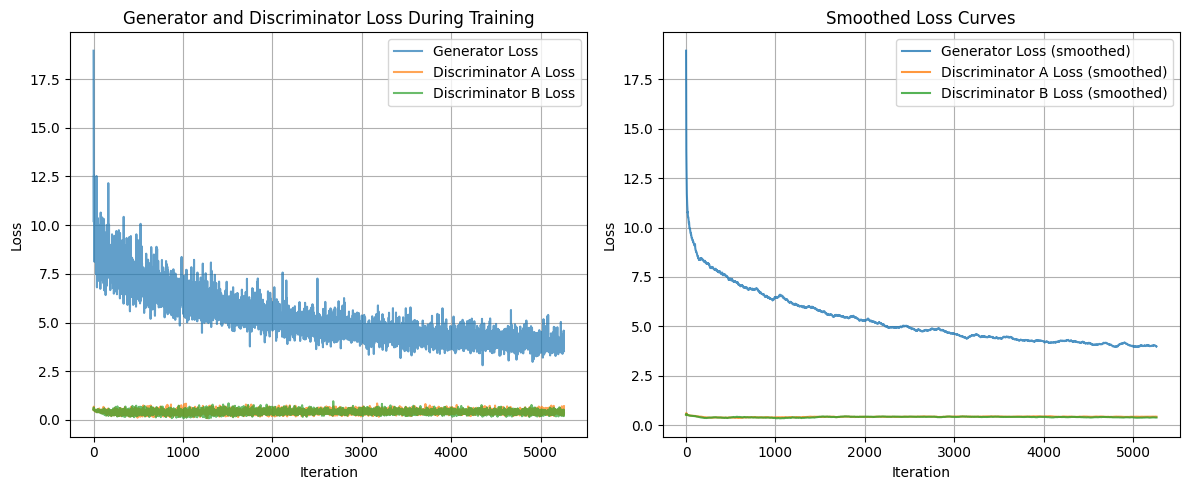

Loss plot saved to: output_cyclegan_s2w\loss_curves.png


In [7]:
# # Plot loss curves for Generator and Discriminator
# plt.figure(figsize=(12, 5))
#
# plt.subplot(1, 2, 1)
# plt.plot(G_losses, label='Generator Loss', alpha=0.7)
# plt.plot(D_A_losses, label='Discriminator A Loss', alpha=0.7)
# plt.plot(D_B_losses, label='Discriminator B Loss', alpha=0.7)
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Generator and Discriminator Loss During Training')
# plt.legend()
# plt.grid(True)
#
# # Smoothed version (moving average)
# plt.subplot(1, 2, 2)
# window = 100
# if len(G_losses) > window:
#     G_smooth = [sum(G_losses[max(0, i - window):i + 1]) / (min(i + 1, window)) for i in range(len(G_losses))]
#     D_A_smooth = [sum(D_A_losses[max(0, i - window):i + 1]) / (min(i + 1, window)) for i in range(len(D_A_losses))]
#     D_B_smooth = [sum(D_B_losses[max(0, i - window):i + 1]) / (min(i + 1, window)) for i in range(len(D_B_losses))]
#
#     plt.plot(G_smooth, label='Generator Loss (smoothed)', alpha=0.8)
#     plt.plot(D_A_smooth, label='Discriminator A Loss (smoothed)', alpha=0.8)
#     plt.plot(D_B_smooth, label='Discriminator B Loss (smoothed)', alpha=0.8)
#
# else:
#     plt.plot(G_losses, label='Generator Loss', alpha=0.7)
#     plt.plot(D_A_losses, label='Discriminator Loss', alpha=0.7)
#     plt.plot(D_B_losses, label='Discriminator Loss', alpha=0.7)
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Smoothed Loss Curves')
# plt.legend()
# plt.grid(True)
#
# plt.tight_layout()
# loss_plot_path = os.path.join(out_dir, "loss_curves.png")
# plt.savefig(loss_plot_path, dpi=150)
# plt.show()
# print(f"Loss plot saved to: {loss_plot_path}")
